***Project:*** Predict future sales  
***Name:*** Juan David Arango Buitrago

### Import libraries and tools

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline 

from tabulate import tabulate
from dict import dict

import featuretools as ft

from feature_selector import FeatureSelector

from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score, mean_squared_error, r2_score

from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

from catboost import CatBoostRegressor

from sklearn.externals import joblib

### Load the Data

In [2]:
train = pd.read_csv('sales_train.csv')
shops = pd.read_csv('shops.csv')
items = pd.read_csv('items.csv')
item_cats = pd.read_csv('item_categories.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

In [3]:
dicti = dict(train=train,
              items=items,
              shops=shops,
              item_categories=item_cats,
              test=test,
              sample=sample)

print("| DataFrame | Rows| Columns|")
for name, frame in dicti.items():
    rows, columns = frame.shape
    print("|{}|{}|{}|".format(name, rows, columns))

| DataFrame | Rows| Columns|
|train|2935849|6|
|items|22170|3|
|shops|60|2|
|item_categories|84|2|
|test|214200|3|
|sample|214200|2|


With the information of the number of columns and rows of the data frames, we can see that a total of 22170 different items are distributed in 84 categories for the 60 stores around Russia.

##### items dataframe

In [4]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [5]:
items.describe()

,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


#### Item categories dataframe

In [6]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [7]:
item_cats.describe()

,item_category_id
count,84.000000
mean,41.500000
std,24.392622
min,0.000000
25%,20.750000
50%,41.500000
75%,62.250000
max,83.000000


#### Shops dataframe

In [8]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [9]:
shops.describe()

,shop_id
count,60.000000
mean,29.500000
std,17.464249
min,0.000000
25%,14.750000
50%,29.500000
75%,44.250000
max,59.000000


#### Train dataframe

In [10]:
pd.options.display.float_format = '{:20,.2f}'.format
train.describe(include="all")

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849,"2,935,849.00","2,935,849.00","2,935,849.00","2,935,849.00","2,935,849.00"
unique,1034,nan,nan,nan,nan,nan
top,28.12.2013,nan,nan,nan,nan,nan
freq,9434,nan,nan,nan,nan,nan
mean,NaN,14.57,33.00,"10,197.23",890.85,1.24
std,NaN,9.42,16.23,"6,324.30","1,729.80",2.62
min,NaN,0.00,0.00,0.00,-1.00,-22.00
25%,NaN,7.00,22.00,"4,476.00",249.00,1.00
50%,NaN,14.00,31.00,"9,343.00",399.00,1.00
75%,NaN,23.00,47.00,"15,684.00",999.00,1.00


In [11]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.00
1,03.01.2013,0,25,2552,899.00,1.00
2,05.01.2013,0,25,2552,899.00,-1.00
3,06.01.2013,0,25,2554,"1,709.05",1.00
4,15.01.2013,0,25,2555,"1,099.00",1.00


In [12]:
# Number of NaNs for each column
train.isnull().sum(axis=0)

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

#### Test dataframe

In [16]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [17]:
 test.describe()

,ID,shop_id,item_id
count,"214,200.00","214,200.00","214,200.00"
mean,"107,099.50",31.64,"11,019.40"
std,"61,834.36",17.56,"6,252.64"
min,0.00,2.00,30.00
25%,"53,549.75",16.00,"5,381.50"
50%,"107,099.50",34.50,"11,203.00"
75%,"160,649.25",47.00,"16,071.50"
max,"214,199.00",59.00,"22,167.00"


In [18]:
# Number of NaNs for each column
test.isnull().sum(axis=0)

ID         0
shop_id    0
item_id    0
dtype: int64

***-***In the train dataFrame, each transaction is per day, and is required to be per month for all shop/item combinations. 

**-**Each month from 2013 to 2015 has a consecutive number (date_block_num), starting from 0 to 33, this same data must be created in the test dataFrame, i.e., number 34.

**-**There are not NaN values for each column in train and test DataFrame

#### Preprocessing

In [55]:
#Change the date format and create features: year and month
train['date'] = pd.to_datetime(train.date, format="%d.%m.%Y")
train["year"] = train.date.dt.year
train["month"] = train.date.dt.month

In [56]:
train.dtypes

date              datetime64[ns]
date_block_num             int64
shop_id                    int64
item_id                    int64
item_price               float64
item_cnt_day             float64
year                       int64
month                      int64
dtype: object

In [57]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month
0,2013-01-02,0,59,22154,999.00,1.00,2013,1
1,2013-01-03,0,25,2552,899.00,1.00,2013,1
2,2013-01-05,0,25,2552,899.00,-1.00,2013,1
3,2013-01-06,0,25,2554,"1,709.05",1.00,2013,1
4,2013-01-15,0,25,2555,"1,099.00",1.00,2013,1


In [58]:
# Merge the feature item_category_id
train1 = pd.merge(train, items, on='item_id', how='inner')
train= train1.drop(['item_name'], axis=1)
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,item_category_id
0,2013-01-02,0,59,22154,999.00,1.00,2013,1,37
1,2013-01-23,0,24,22154,999.00,1.00,2013,1,37
2,2013-01-20,0,27,22154,999.00,1.00,2013,1,37
3,2013-01-02,0,25,22154,999.00,1.00,2013,1,37
4,2013-01-03,0,25,22154,999.00,1.00,2013,1,37


In [59]:
# Merge the feature item_category_id to test dataframe

test1 = pd.merge(test, items, on='item_id', how='inner')
test1= test1.drop(['item_name'], axis=1)
test1.head()

,ID,shop_id,item_id,item_category_id
0,0,5,5037,19
1,5100,4,5037,19
2,10200,6,5037,19
3,15300,3,5037,19
4,20400,2,5037,19


In [6]:
# create date_block_num
test_block = train['date_block_num'].iloc[-1] + 1
test1['date_block_num'] = test_block
test1.head()

,ID,shop_id,item_id,item_category_id,date_block_num
0,0,5,5037,19,34
1,5100,4,5037,19,34
2,10200,6,5037,19,34
3,15300,3,5037,19,34
4,20400,2,5037,19,34


In [7]:
# create month november
test1['month'] = 11

### Exploratory Data Analysis

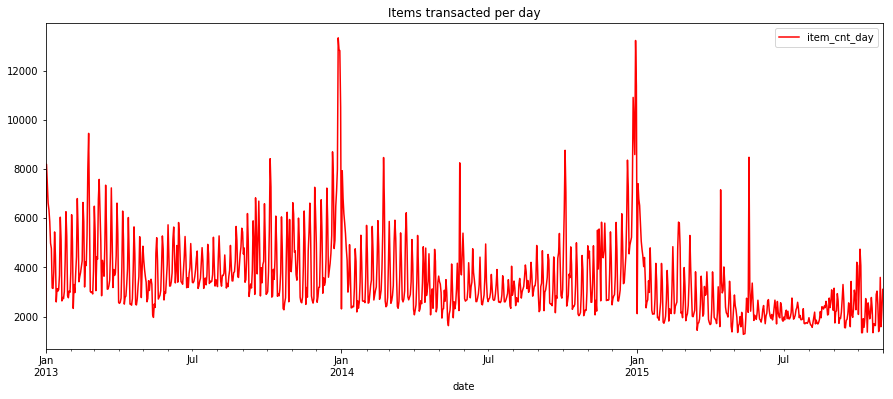

In [60]:
train.groupby('date').agg({"item_cnt_day": "sum"}).plot(figsize=(15,6),color="red",title="Items transacted per day")

***-***From the previous graph, it can be seen that a purchasing pattern occurs in the first months of the year and the first of the following year, but a decrease in the number of transactions is observed between each month from January 2013 to October 2015.

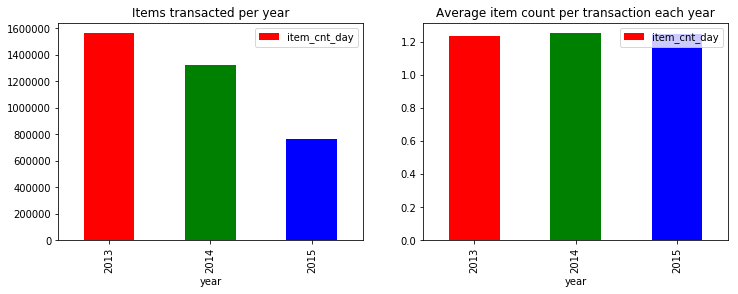

In [61]:
fig, axes = plt.subplots(1,2, figsize=(33,5))
train.groupby('year').agg({"item_cnt_day": "sum"}).plot.bar(figsize=(12,4),color=['rgbkymc'],title="Items transacted per year",ax=axes[0])
train.groupby('year').agg({"item_cnt_day": "mean"}).plot.bar(figsize=(12,4),color=['rgbkymc'],title="Average item count per transaction each year",ax=axes[1])

**-**Although it observes that the total number of transactions has decreased, it must be taken into account that it is missing due to having the data for the months of November and December 2015, which, as previously mentioned, are the months where sales by holidays.  the average daily item count per transaction is the same each year presenting a slight increase in 2014

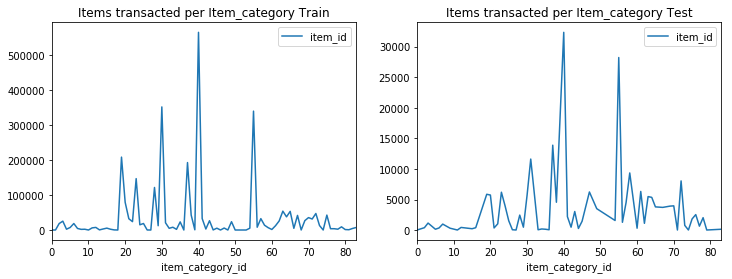

In [62]:
fig, axes = plt.subplots(1,2, figsize=(33,5))
train.groupby("item_category_id").agg({"item_id": "count"}).plot(figsize=(12, 4),ax=axes[0],title="Items transacted per Item_category Train")
test1.groupby("item_category_id").agg({"item_id": "count"}).plot(figsize=(12, 4),ax=axes[1],title="Items transacted per Item_category Test")

**-**Both, the train DataFrame and the test DataFrame, you can see that there are some categories that present a similar pattern according to the number of sales of the items in that category. This allows determining that the category may be important for the prediction model.

In [63]:
train_2013 = train[(train['year'] == 2013)& (train['month'] == 11)]
train_2013.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,item_category_id
104,2013-11-17,10,27,2555,"1,149.00",1.00,2013,11,56
105,2013-11-23,10,31,2555,"1,149.00",1.00,2013,11,56
106,2013-11-29,10,6,2555,"1,149.00",1.00,2013,11,56
107,2013-11-16,10,57,2555,"1,149.00",1.00,2013,11,56
108,2013-11-25,10,50,2555,"1,149.00",1.00,2013,11,56


In [64]:
train_2014 = train[(train['year'] == 2014)& (train['month'] == 11)]
train_2014.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,item_category_id
2246,2014-11-24,22,33,2574,399.00,1.00,2014,11,55
2247,2014-11-26,22,35,2574,399.00,1.00,2014,11,55
2248,2014-11-26,22,59,2574,399.00,1.00,2014,11,55
2249,2014-11-09,22,59,2574,399.00,1.00,2014,11,55
2250,2014-11-18,22,37,2574,399.00,1.00,2014,11,55


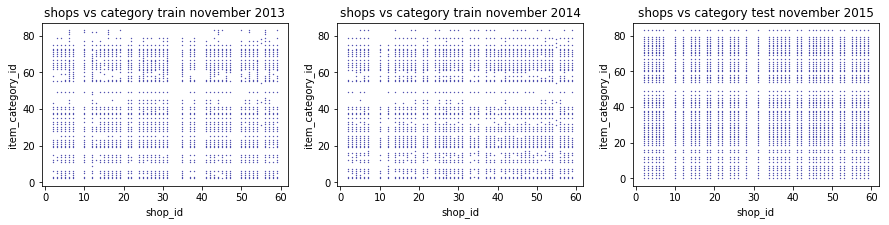

In [67]:
# plot items for each shop -- training set vs test set
fix, axes = plt.subplots(1,3,figsize=(15,3))

train_2013.drop_duplicates(subset=['shop_id', 'item_category_id']).plot.scatter('shop_id', 'item_category_id', color='DarkBlue', s = 0.1, ax=axes[0], title="shops vs category train november 2013")
train_2014.drop_duplicates(subset=['shop_id', 'item_category_id']).plot.scatter('shop_id', 'item_category_id', color='DarkBlue', s = 0.1, ax=axes[1], title="shops vs category train november 2014")
test1.drop_duplicates(subset=['shop_id', 'item_category_id']).plot.scatter('shop_id', 'item_category_id', color='DarkBlue', s = 0.1, ax=axes[2], title="shops vs category test november 2015")

***-***Making the comparison of the month of November of the years 2013, 2014, 2015, it can be seen that as well as some items (and in turn the categories), they do not have transactions in some of the stores. What could be done is only take into account the data of the stores that register at least 1 transaction in the month of November 2015 and not with all the data of the stores

#### Aggregate new features to our model

In [8]:
#Count item_cnt_day per month
train_m1=train.groupby(["shop_id","item_id","item_category_id","date_block_num","month","item_price"],
                       as_index=False).agg({"item_cnt_day":["sum"]})
print(train_m1.shape)

(1739022, 7)


In [9]:
train_m1.head()

,shop_id,item_id,item_category_id,date_block_num,month,item_price,item_cnt_day
,,,,,,,sum
0,0,30,40,1,2,265.0,31.0
1,0,31,37,1,2,434.0,11.0
2,0,32,40,0,1,221.0,6.0
3,0,32,40,1,2,221.0,10.0
4,0,33,37,0,1,347.0,3.0


In [10]:
train_m1.columns = train_m1.columns.get_level_values(0)
train_m1.columns=["shop_id","item_id","item_category_id","date_block_num","month","item_price","item_cnt_month"]
train_m1.head()

,shop_id,item_id,item_category_id,date_block_num,month,item_price,item_cnt_month
0,0,30,40,1,2,265.0,31.0
1,0,31,37,1,2,434.0,11.0
2,0,32,40,0,1,221.0,6.0
3,0,32,40,1,2,221.0,10.0
4,0,33,37,0,1,347.0,3.0


In [11]:
# Calculate range by item_price

train_m1['price_cat'] = pd.qcut(train_m1['item_price'], q=5, precision=0)
train_m1.head()

,shop_id,item_id,item_category_id,date_block_num,month,item_price,item_cnt_month,price_cat
0,0,30,40,1,2,265.0,31.0,"(199.0, 299.0]"
1,0,31,37,1,2,434.0,11.0,"(299.0, 499.0]"
2,0,32,40,0,1,221.0,6.0,"(199.0, 299.0]"
3,0,32,40,1,2,221.0,10.0,"(199.0, 299.0]"
4,0,33,37,0,1,347.0,3.0,"(299.0, 499.0]"


In [12]:
#Create a Label encoding by price

df = preprocessing.LabelEncoder()
df.fit(train_m1['price_cat'])
train_m1['price_cat']=df.transform(train_m1['price_cat'])
train_m1.tail()

,shop_id,item_id,item_category_id,date_block_num,month,item_price,item_cnt_month,price_cat
1739017,59,22164,37,27,4,699.0,2.0,3
1739018,59,22164,37,30,7,699.0,1.0,3
1739019,59,22167,49,9,10,299.0,1.0,1
1739020,59,22167,49,11,12,299.0,2.0,1
1739021,59,22167,49,17,6,299.0,1.0,1


In [13]:
#create a new feature, 1 if the item is sold in november and 0 otherwise

B= train_m1[['shop_id','item_id', 'month']]
B1= B[B['month'] == 11]
B1['nov_item']=1
B2=B1.drop(['month'], axis=1)

/home/judarangobu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
train_m1 = train_m1.merge(B2, on=['shop_id','item_id'], how='left')

In [15]:
train_m1['nov_item'].fillna(0, inplace=True) 
train_m1.head()

,shop_id,item_id,item_category_id,date_block_num,month,item_price,item_cnt_month,price_cat,nov_item
0,0,30,40,1,2,265.0,31.0,1,0.0
1,0,31,37,1,2,434.0,11.0,2,0.0
2,0,32,40,0,1,221.0,6.0,1,0.0
3,0,32,40,1,2,221.0,10.0,1,0.0
4,0,33,37,0,1,347.0,3.0,2,0.0


In [16]:
train_m2= train_m1

In [17]:
train1_m1=train_m1.drop(['item_price'], axis=1)

##### Create mean encoding of item_id, Shop_it and item_category_id

In [18]:
train_m1['item_cntmonth_mean'] = train_m1.groupby('item_id')['item_cnt_month'].transform('mean')

# Fill NaNs
train_m1['item_cntmonth_mean'].fillna(train_m1.item_cntmonth_mean.mean(), inplace=True) 

train_m1['item_cntmonth_std'] = train_m1.groupby('item_id')['item_cnt_month'].transform('std')

# Fill NaNs
train_m1['item_cntmonth_std'].fillna(train_m1.item_cntmonth_std.mean(), inplace=True)

In [19]:
train_m1['shop_cntmonth_mean'] = train_m1.groupby('shop_id')['item_cnt_month'].transform('mean')

# Fill NaNs
train_m1['shop_cntmonth_mean'].fillna(train_m1.item_cntmonth_mean.mean(), inplace=True)

train_m1['shop_cntmonth_std'] = train_m1.groupby('shop_id')['item_cnt_month'].transform('std')

# Fill NaNs
train_m1['shop_cntmonth_std'].fillna(train_m1.shop_cntmonth_std.mean(), inplace=True) 

In [20]:
train_m1['cat_cntmonth_mean'] = train_m1.groupby('item_category_id')['item_cnt_month'].transform('mean')

# Fill NaNs
train_m1['cat_cntmonth_mean'].fillna(train_m1.item_cntmonth_mean.mean(), inplace=True)

train_m1['cat_cntmonth_std'] = train_m1.groupby('item_category_id')['item_cnt_month'].transform('std')

# Fill NaNs
train_m1['cat_cntmonth_std'].fillna(train_m1.shop_cntmonth_std.mean(), inplace=True)

In [21]:
train_m1.head()

,shop_id,item_id,item_category_id,date_block_num,month,item_price,item_cnt_month,price_cat,nov_item,item_cntmonth_mean,item_cntmonth_std,shop_cntmonth_mean,shop_cntmonth_std,cat_cntmonth_mean,cat_cntmonth_std
0,0,30,40,1,2,265.0,31.0,1,0.0,4.458084,9.056033,2.406456,3.819208,1.911038,3.309685
1,0,31,37,1,2,434.0,11.0,2,0.0,2.344603,3.581579,2.406456,3.819208,1.435126,1.467867
2,0,32,40,0,1,221.0,6.0,1,0.0,2.883721,3.750552,2.406456,3.819208,1.911038,3.309685
3,0,32,40,1,2,221.0,10.0,1,0.0,2.883721,3.750552,2.406456,3.819208,1.911038,3.309685
4,0,33,37,0,1,347.0,3.0,2,0.0,1.481928,0.931314,2.406456,3.819208,1.435126,1.467867


In [22]:
train_m1.isnull().sum()

shop_id               0
item_id               0
item_category_id      0
date_block_num        0
month                 0
item_price            0
item_cnt_month        0
price_cat             0
nov_item              0
item_cntmonth_mean    0
item_cntmonth_std     0
shop_cntmonth_mean    0
shop_cntmonth_std     0
cat_cntmonth_mean     0
cat_cntmonth_std      0
dtype: int64

#### Create a new feature with featuretools library

In [23]:
#Create a unique ID for each row
train_m1["id_train"] = train_m1.index + 1

In [25]:
train_3=train_m1.drop(['item_cnt_month'], axis=1)

In [26]:
train_3.head()

,shop_id,item_id,item_category_id,date_block_num,month,item_price,price_cat,nov_item,item_cntmonth_mean,item_cntmonth_std,shop_cntmonth_mean,shop_cntmonth_std,cat_cntmonth_mean,cat_cntmonth_std,id_train
0,0,30,40,1,2,265.0,1,0.0,4.458084,9.056033,2.406456,3.819208,1.911038,3.309685,1
1,0,31,37,1,2,434.0,2,0.0,2.344603,3.581579,2.406456,3.819208,1.435126,1.467867,2
2,0,32,40,0,1,221.0,1,0.0,2.883721,3.750552,2.406456,3.819208,1.911038,3.309685,3
3,0,32,40,1,2,221.0,1,0.0,2.883721,3.750552,2.406456,3.819208,1.911038,3.309685,4
4,0,33,37,0,1,347.0,2,0.0,1.481928,0.931314,2.406456,3.819208,1.435126,1.467867,5


In [35]:
target=train_m1['item_cnt_month']

In [27]:
#Create an EntitySet that contains multiple dataframes and relationships between them
es = ft.EntitySet(id = 'target')

In [28]:
es.entity_from_dataframe(entity_id = 'train_f', dataframe = train_3, index = 'id_train')

Entityset: target
  Entities:
    train_f [Rows: 2171749, Columns: 15]
  Relationships:
    No relationships

In [29]:
#Crate a new table frome train dataframe based on item

es.normalize_entity(base_entity_id='train_f', new_entity_id='train_r', index = 'item_id', 
additional_variables = ['item_category_id','item_cntmonth_mean', 'item_cntmonth_std', 'nov_item'])

Entityset: target
  Entities:
    train_f [Rows: 2171749, Columns: 11]
    train_r [Rows: 21807, Columns: 5]
  Relationships:
    train_f.item_id -> train_r.item_id

In [30]:
# We use Deep Feature Synthesis to create new features automatically

feature_matrix, feature_names = ft.dfs(entityset=es, 
target_entity = 'train_f', 
max_depth = 2, 
verbose = 1, 
n_jobs = 3)

Built 69 features
Elapsed: 00:00 | Progress:   0%|          

/home/judarangobu/anaconda3/lib/python3.6/site-packages/distributed/dashboard/core.py:20: UserWarning: 
Dask needs bokeh >= 0.13.0 for the dashboard.
Continuing without the dashboard.
  "\nDask needs bokeh >= 0.13.0 for the dashboard."
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Cou

EntitySet scattered to 3 workers in 60 seconds
Elapsed: 06:32 | Progress:  95%|█████████▌

distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing


Elapsed: 09:07 | Progress: 100%|██████████


In [31]:
#new dataframe with all old and new features

feature_matrix.head()

,shop_id,item_id,date_block_num,month,item_price,price_cat,shop_cntmonth_mean,shop_cntmonth_std,cat_cntmonth_mean,cat_cntmonth_std,...,train_r.MEAN(train_f.date_block_num),train_r.MEAN(train_f.cat_cntmonth_mean),train_r.MEAN(train_f.price_cat),train_r.MEAN(train_f.shop_cntmonth_std),train_r.MEAN(train_f.shop_id),train_r.MEAN(train_f.cat_cntmonth_std),train_r.MEAN(train_f.month),train_r.MEAN(train_f.item_price),train_r.MEAN(train_f.shop_cntmonth_mean),train_r.COUNT(train_f)
id_train,,,,,,,,,,,,,,,,,,,,,
1,0,30,1,2,265.0,1,2.406456,3.819208,1.911038,3.309685,...,11.149701,1.911038,0.863772,9.069633,32.232036,3.309685,5.574850,264.375491,2.458847,668
2,0,31,1,2,434.0,2,2.406456,3.819208,1.435126,1.467867,...,13.368010,1.435126,2.262679,9.787637,31.512354,1.467867,5.660598,517.463466,2.533196,769
3,0,32,0,1,221.0,1,2.406456,3.819208,1.911038,3.309685,...,13.648579,1.911038,0.736434,7.826796,32.058570,3.309685,6.007752,219.614451,2.324415,1161
4,0,32,1,2,221.0,1,2.406456,3.819208,1.911038,3.309685,...,13.648579,1.911038,0.736434,7.826796,32.058570,3.309685,6.007752,219.614451,2.324415,1161
5,0,33,0,1,347.0,2,2.406456,3.819208,1.435126,1.467867,...,14.278830,1.435126,0.333907,8.285690,31.094664,1.467867,6.005164,245.558520,2.413390,581


### Select best features to our model

In [ ]:
X_train = feature_matrix.drop(['item_cnt_month'], axis=1)

In [36]:
fs = FeatureSelector(data = feature_matrix, labels = target)

In [37]:
# Pass in the appropriate parameters

# We use the method Zero importance to select the best features to our model

fs.identify_zero_importance(task = 'regression', 
                            eval_metric = 'mse', 
                            n_iterations = 3, 
                             early_stopping = True)
# list of zero importance features
zero_importance_features = fs.ops['zero_importance']

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[996]	valid_0's l2: 26.6067
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 19.272
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 30.3052

9 features with zero importance after one-hot encoding.



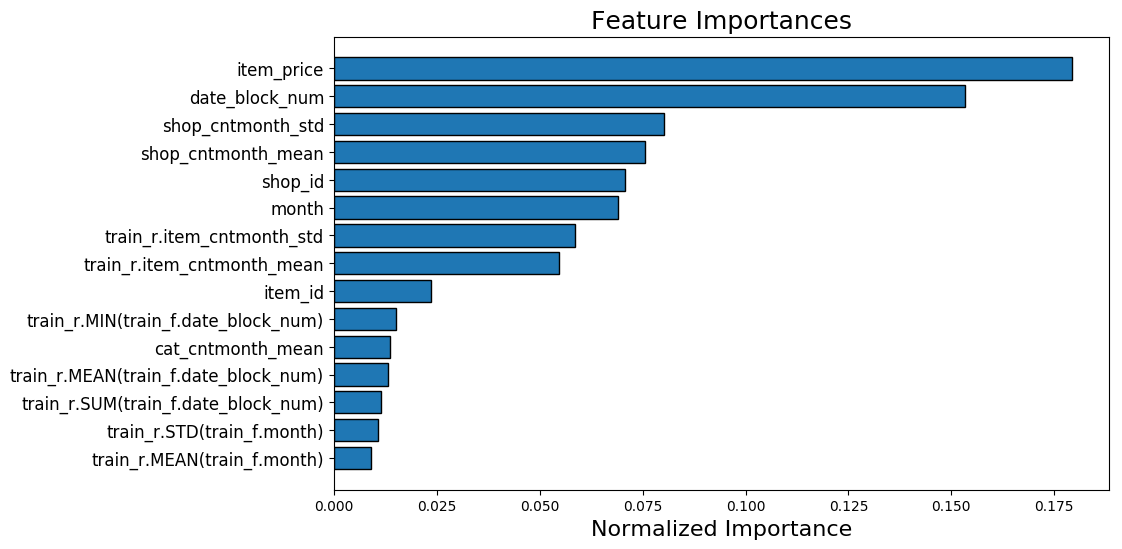

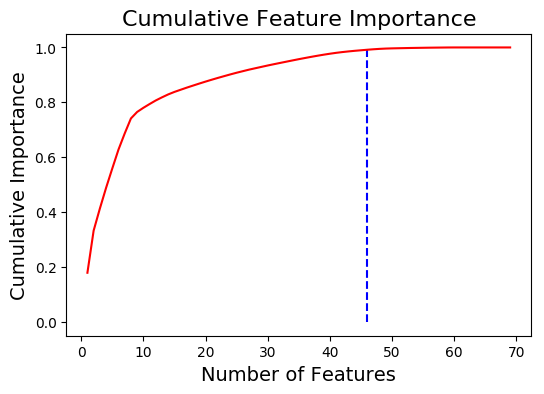

46 features required for 0.99 of cumulative importance


In [38]:
# plot the feature importances
fs.plot_feature_importances(threshold = 0.99, plot_n = 15)

In [39]:
# Remove 9 features with zero importance
train_final = fs.remove(methods = 'all')

['zero_importance'] methods have been run

Removed 9 features.


### Train/validation split

***-*** We use a hold-out as a validation strategy, split the train dataset in two parts (80 % for train and 20 % por validation)

In [44]:
#split the train and validation set
X_train, X_val, y_train, y_val = train_test_split(train_final, target, test_size=0.2, random_state=0)

In [59]:
#Select the parameter of the model
model = CatBoostRegressor(depth=16, iterations=50, learning_rate=0.1,random_seed=25,silent=True)

In [60]:
# Training the model
model.fit(X_train, y_train)

In [61]:
# Predict
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_val)

In [62]:
# Results
print("Resultados en los datos de entrenamiento")
print('  RMSE: {}'.format(np.sqrt(mean_squared_error(y_train, Y_train_pred))))
print('  R2: {}'.format(r2_score(y_train, Y_train_pred)))
print('')
print("Resultados en los datos de validacion")
print('  RMSE: {}'.format(np.sqrt(mean_squared_error(y_val, Y_test_pred))))
print('  R2: {}'.format(r2_score(y_val, Y_test_pred)))

print('Model is fitted: ' + str(model.is_fitted()))

Resultados en los datos de entrenamiento
  RMSE: 4.325241326205401
  R2: 0.8915711722891612

Resultados en los datos de validacion
  RMSE: 5.268588397519882
  R2: 0.8099294820250157
Model is fitted: True


### Test the data with the model

In [63]:
test1.head()

,ID,shop_id,item_id,item_category_id,date_block_num,month
0,0,5,5037,19,34,11
1,5100,4,5037,19,34,11
2,10200,6,5037,19,34,11
3,15300,3,5037,19,34,11
4,20400,2,5037,19,34,11


In [64]:
#Remove 2 features from train_final
B2=train_final.drop(['date_block_num','month'], axis=1)

In [65]:
#Remove 1 features from test1
test1=test1.drop(['item_category_id'], axis=1)

In [66]:
test2 = pd.merge(test1, B2, on=['shop_id','item_id'], how='left')

In [67]:
test3=test2.drop_duplicates(subset=['shop_id','item_id'])

In [68]:
print(test1.shape)
print(test3.shape)

(214200, 5)
(214200, 61)


In [69]:
#Create the ID

ID=test3[['ID']]
X_test=test3.drop(['ID'], axis=1)

In [73]:
#Predict the test dataframe
preds = model.predict(X_test)

In [74]:
# Merge the ID with preds
output=pd.DataFrame()
output["ID"]=test3["ID"]
output["item_cnt_month"]=preds
output.head()

,ID,item_cnt_month
0,0,1.668570
11,5100,1.707197
14,10200,1.979977
26,15300,1.643979
35,20400,1.643979


In [75]:
output.to_csv('submission8.csv',index=False)